In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


In [2]:
# Load smoothed datasets from all 8 clusters
import os

data_dir = 'data/smoothed'
all_dfs = []

for i in range(1, 9):
    filepath = os.path.join(data_dir, f'smoothed_cluster_{i}.csv')
    df = pd.read_csv(filepath)
    all_dfs.append(df)
    print(f"Cluster {i}: {len(df)} rows")

# Combine all clusters into one dataset
df = pd.concat(all_dfs, ignore_index=True)
print(f"\nCombined dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(10))
print(f"\nData statistics:")
print(df[['cpu', 'memory']].describe())

features = df[['cpu', 'memory']].values

# norm using minmax
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

print(f"\nNormalized data shape: {features_normalized.shape}")

Cluster 1: 397 rows
Cluster 2: 558 rows
Cluster 3: 959 rows
Cluster 4: 336 rows
Cluster 5: 554 rows
Cluster 6: 611 rows
Cluster 7: 534 rows
Cluster 8: 496 rows

Combined dataset shape: (4445, 4)

First few rows:
   cluster  time       cpu    memory
0        1     0  0.002942  0.005785
1        1   300  0.003434  0.005983
2        1   600  0.003824  0.005747
3        1   900  0.003884  0.005806
4        1  1200  0.003615  0.005162
5        1  1500  0.003686  0.003919
6        1  1800  0.002743  0.002654
7        1  2100  0.002640  0.002542
8        1  2400  0.002619  0.002425
9        1  2700  0.001235  0.002119

Data statistics:
               cpu       memory
count  4445.000000  4445.000000
mean      0.005848     0.002994
std       0.004034     0.001691
min       0.000115     0.000121
25%       0.002949     0.001654
50%       0.004934     0.002778
75%       0.007913     0.004050
max       0.031862     0.012856

Normalized data shape: (4445, 2)


In [3]:
# create non-overlapping sequences (6 timesteps = 30 min lookback)
def create_sequences(data, seq_length=6):
    """
    Create NON-OVERLAPPING sequences for time series (ignoring timestamps)
    
    params:
        data: Normalized feature array (n_samples, n_features)
        seq_length: Number of timesteps in each sequence (default: 6 for 30 min)
    
    returns:
        X: Input sequences (n_sequences, seq_length, n_features)
        y: Target values (n_sequences, n_features)
    """
    X, y = [], []
    
    for i in range(0, len(data) - seq_length, seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    
    return np.array(X), np.array(y)

SEQ_LENGTH = 6
X, y = create_sequences(features_normalized, seq_length=SEQ_LENGTH)

print(f"Input sequences shape: {X.shape}")  # (n_sequences, 6, 2)
print(f"Target values shape: {y.shape}")    # (n_sequences, 2)
print(f"\nTotal sequences created: {len(X)}")
print(f"Each sequence has {SEQ_LENGTH} timesteps with {X.shape[2]} features")
print(f"\nWith non-overlapping chunks: {len(features_normalized)} rows / {SEQ_LENGTH} = ~{len(X)} sequences")
print(f"\nSample sequence (first):")
print(f"Input shape: {X[0].shape}")
print(f"Target: {y[0]}")

Input sequences shape: (740, 6, 2)
Target values shape: (740, 2)

Total sequences created: 740
Each sequence has 6 timesteps with 2 features

With non-overlapping chunks: 4445 rows / 6 = ~740 sequences

Sample sequence (first):
Input shape: (6, 2)
Target: [0.08278127 0.19888184]


In [4]:
# split + dataloaders
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train set: {X_train.shape[0]} sequences")
print(f"Test set: {X_test.shape[0]} sequences")
print(f"Split ratio: {train_size/len(X)*100:.1f}% train, {(1-train_size/len(X))*100:.1f}% test")

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# dataloaders
BATCH_SIZE = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# preview one
sample_batch_X, sample_batch_y = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"  Input: {sample_batch_X.shape}")   # (batch_size, 6, 2)
print(f"  Target: {sample_batch_y.shape}")  # (batch_size, 2)

Train set: 592 sequences
Test set: 148 sequences
Split ratio: 80.0% train, 20.0% test

Batch size: 32
Number of training batches: 19
Number of test batches: 5

Sample batch shapes:
  Input: torch.Size([32, 6, 2])
  Target: torch.Size([32, 2])


In [5]:
# LSTM Model Architecture
class TrafficPredictor(nn.Module):
    """
    LSTM-based model for predicting CPU and memory utilization.
    
    arch:
    - Input: (batch, seq_length=6, features=2)
    - LSTM Layer 1: 64 hidden units with dropout
    - LSTM Layer 2: 32 hidden units with dropout
    - Dense layers: 32 -> 16 -> 2 (CPU and memory predictions)
    """
    def __init__(self, input_size=2, hidden_size1=64, hidden_size2=32, dropout=0.2, output_size=2):
        super(TrafficPredictor, self).__init__()
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        
        # Dense layers
        self.fc1 = nn.Linear(hidden_size2, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_size)
        
    def forward(self, x):
        # x shape: (batch, seq_length, features)
        
        # LSTM layer 1
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.dropout1(lstm_out1)
        
        # LSTM layer 2
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)
        
        # last timestep output
        last_output = lstm_out2[:, -1, :]  # (batch, hidden_size2)
        
        # apply dense layers (lin fully connect)
        out = self.fc1(last_output)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)  # (batch, 2) - CPU and memory predictions
        
        return out

# init
model = TrafficPredictor().to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# forward pass
test_input = torch.randn(BATCH_SIZE, SEQ_LENGTH, 2).to(device)
test_output = model(test_input)
print(f"\nTest forward pass:")
print(f"  Input shape: {test_input.shape}")
print(f"  Output shape: {test_output.shape}")

Model Architecture:
TrafficPredictor(
  (lstm1): LSTM(2, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

Total parameters: 31,570
Trainable parameters: 31,570

Test forward pass:
  Input shape: torch.Size([32, 6, 2])
  Output shape: torch.Size([32, 2])


In [6]:
# loss function and optimizer init
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# other hyperparams
NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 15

print("Training Configuration:")
print(f"  Loss function: MSE (Mean Squared Error)")
print(f"  Optimizer: Adam")
print(f"  Learning rate: 0.001")
print(f"  Number of epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {EARLY_STOP_PATIENCE}")
print(f"  Device: {device}")

Training Configuration:
  Loss function: MSE (Mean Squared Error)
  Optimizer: Adam
  Learning rate: 0.001
  Number of epochs: 100
  Early stopping patience: 15
  Device: cuda


In [7]:
# train loop
train_losses = []
test_losses = []
best_test_loss = float('inf')
patience_counter = 0

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # eval for test
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            test_loss += loss.item()
    
    # test loss
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
    
    # early stop maybe
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            print(f"Best test loss: {best_test_loss:.6f}")
            model.load_state_dict(best_model_state)
            break

print("\n" + "="*50)
print("Training Complete!")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss: {test_losses[-1]:.6f}")
print(f"Best Test Loss: {best_test_loss:.6f}")
print("="*50)

Starting training...

Epoch [1/100] - Train Loss: 0.033434, Test Loss: 0.035632
Epoch [10/100] - Train Loss: 0.011020, Test Loss: 0.022071
Epoch [20/100] - Train Loss: 0.006757, Test Loss: 0.016382
Epoch [30/100] - Train Loss: 0.005909, Test Loss: 0.015758
Epoch [40/100] - Train Loss: 0.005896, Test Loss: 0.014760
Epoch [50/100] - Train Loss: 0.005484, Test Loss: 0.014869

Early stopping triggered at epoch 58
Best test loss: 0.014158

Training Complete!
Final Train Loss: 0.005108
Final Test Loss: 0.014212
Best Test Loss: 0.014158


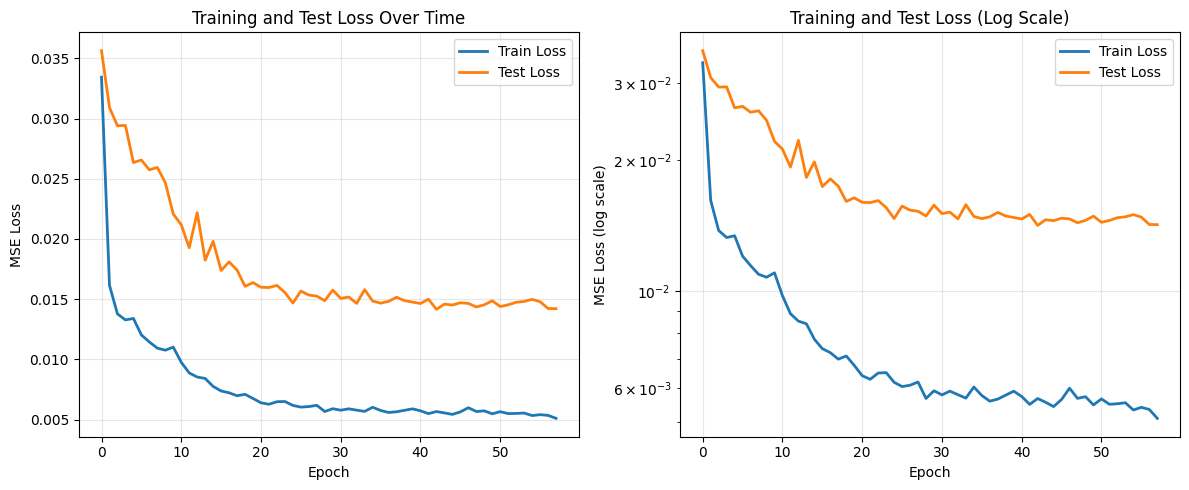

Total epochs trained: 58
Best test loss achieved: 0.014158 at epoch 43


In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('Training and Test Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total epochs trained: {len(train_losses)}")
print(f"Best test loss achieved: {min(test_losses):.6f} at epoch {test_losses.index(min(test_losses))+1}")

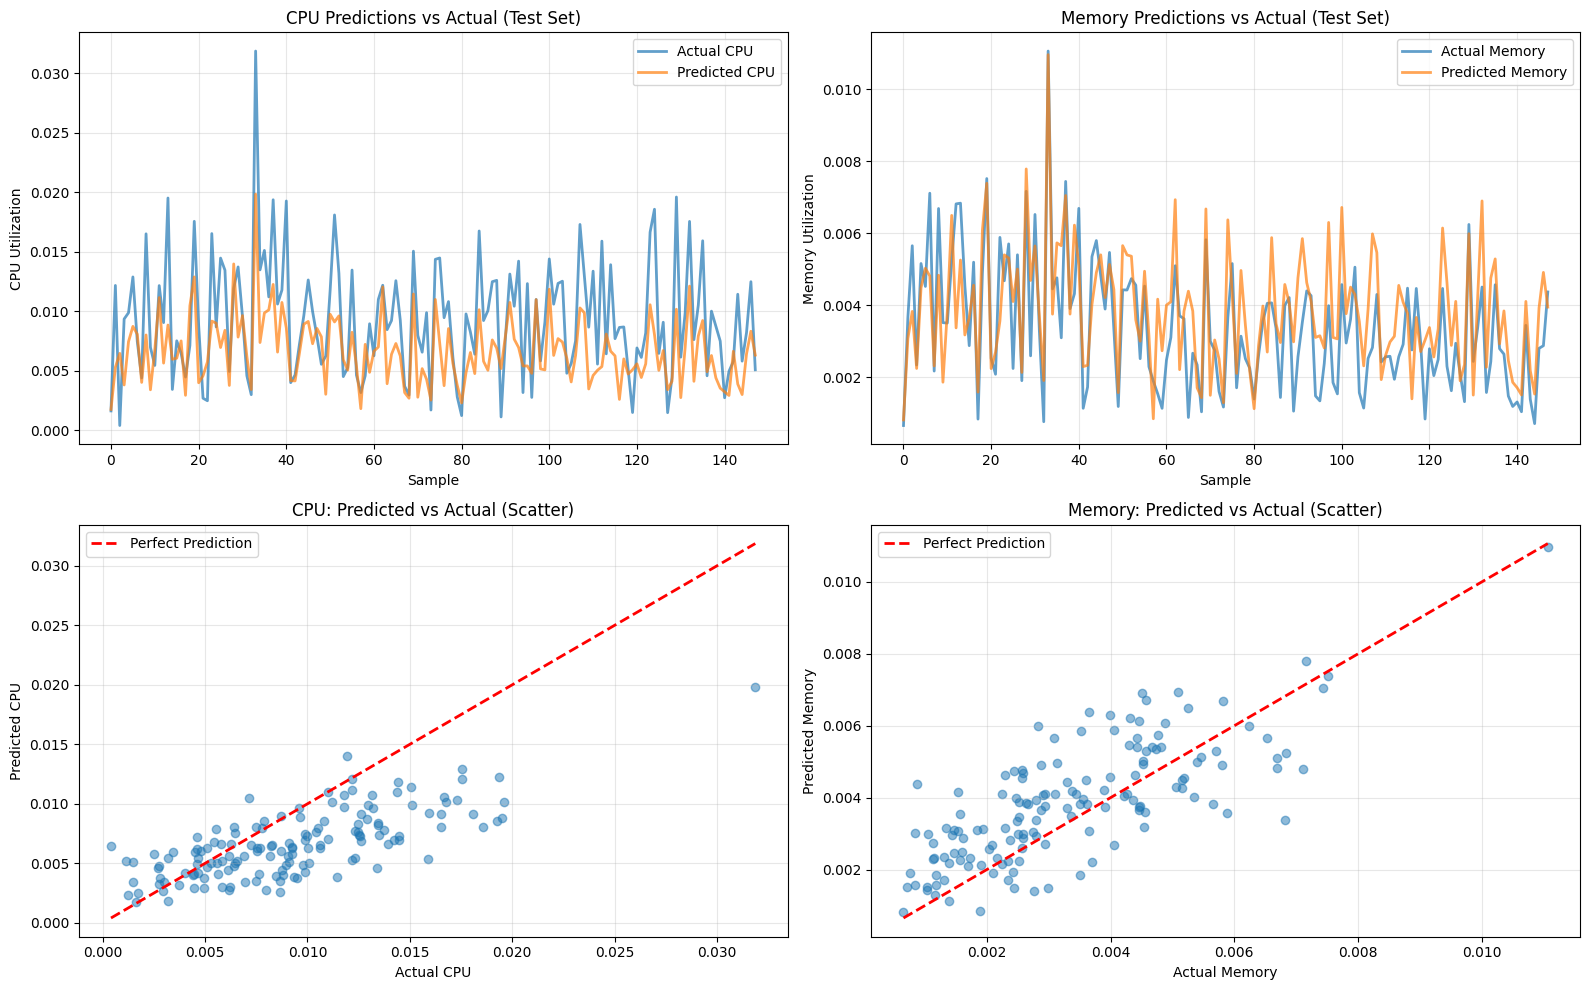

In [9]:
# test preds
model.eval()

with torch.no_grad():
    y_pred_test = model(X_test_tensor).cpu().numpy()
    y_true_test = y_test_tensor.cpu().numpy()

y_pred_actual = scaler.inverse_transform(y_pred_test)
y_true_actual = scaler.inverse_transform(y_true_test)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CPU Predictions vs Actual (first 200 samples)
n_samples = min(200, len(y_true_actual))
axes[0, 0].plot(y_true_actual[:n_samples, 0], label='Actual CPU', linewidth=2, alpha=0.7)
axes[0, 0].plot(y_pred_actual[:n_samples, 0], label='Predicted CPU', linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('CPU Utilization')
axes[0, 0].set_title('CPU Predictions vs Actual (Test Set)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Memory Predictions vs Actual (first 200 samples)
axes[0, 1].plot(y_true_actual[:n_samples, 1], label='Actual Memory', linewidth=2, alpha=0.7)
axes[0, 1].plot(y_pred_actual[:n_samples, 1], label='Predicted Memory', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Sample')
axes[0, 1].set_ylabel('Memory Utilization')
axes[0, 1].set_title('Memory Predictions vs Actual (Test Set)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# CPU Scatter Plot
axes[1, 0].scatter(y_true_actual[:, 0], y_pred_actual[:, 0], alpha=0.5)
axes[1, 0].plot([y_true_actual[:, 0].min(), y_true_actual[:, 0].max()], 
                [y_true_actual[:, 0].min(), y_true_actual[:, 0].max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual CPU')
axes[1, 0].set_ylabel('Predicted CPU')
axes[1, 0].set_title('CPU: Predicted vs Actual (Scatter)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Memory Scatter Plot
axes[1, 1].scatter(y_true_actual[:, 1], y_pred_actual[:, 1], alpha=0.5)
axes[1, 1].plot([y_true_actual[:, 1].min(), y_true_actual[:, 1].max()], 
                [y_true_actual[:, 1].min(), y_true_actual[:, 1].max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Memory')
axes[1, 1].set_ylabel('Predicted Memory')
axes[1, 1].set_title('Memory: Predicted vs Actual (Scatter)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import r2_score

# R² for CPU (column 0)
r2_cpu = r2_score(y_true_actual[:, 0], y_pred_actual[:, 0])

# R² for Memory (column 1)
r2_mem = r2_score(y_true_actual[:, 1], y_pred_actual[:, 1])

print("R² CPU:", r2_cpu)
print("R² Memory:", r2_mem)

R² CPU: 0.22569608688354492
R² Memory: 0.4679967761039734


In [10]:
# Export model, scaler, and config for inference
import pickle

# Create models directory
os.makedirs('models', exist_ok=True)

# Save model weights
model_path = 'models/traffic_predictor.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Save scaler for inference
scaler_path = 'models/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}")

# Save model config
config = {
    'input_size': 2,
    'hidden_size1': 64,
    'hidden_size2': 32,
    'dropout': 0.2,
    'output_size': 2,
    'seq_length': SEQ_LENGTH,
    'batch_size': BATCH_SIZE,
    'best_test_loss': best_test_loss
}

config_path = 'models/config.pkl'
with open(config_path, 'wb') as f:
    pickle.dump(config, f)
print(f"Config saved to {config_path}")

print(f"\nAll artifacts exported to models/ directory")

Model saved to models/traffic_predictor.pth
Scaler saved to models/scaler.pkl
Config saved to models/config.pkl

All artifacts exported to models/ directory
